# Лабораторная работа 1. Линейная регрессия и факторный аналииз
## Описание работы
### Цель работы:
изучение основ линейной регресии, построение простейших моделей регрессии, проведение обучения модели на реальных данных и оценка её качества.
### Постановка задачи:
Провести обучение модели линейной регрессии на датасете:
1. Загрузить датасет
2. Подготовить данные: провести первичный анализ, визуализировать распределение признаков и целевой переменной
3. Провести предобработку данных: удалить пропущенные значения
4. Построить матрицу корреляций. Сделать выводы о наличии мультиколлинеарности.
5. Построить регрессионные модели (линейная и гребневая). Разделить на тренировочную и тестовую выборки (80/20 или 70/30). Использовать кросс-валидацию. Оценить качество построенной модели с помощью метрик: RMSE (Root Mean Square Error), R² (коэффициент детерминации) и MAPE (Mean Absolute Percentage Error).
6. Устранить мультиколлинеарность и снизить размерность признаков с помощью метода главных компонент (PCA).
7. Повторить шаг 5 (линейная и гребневая регрессия), но использовать в качестве признаков не исходные данные, а главные компоненты. Сравнить метрики качества (RMSE, R² и MAPE) моделей, обученных на исходных данных и на главных компонентах.

## Загрузка датасета и первичный анализ данных

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("house_prices_dataset.csv")
df_selected = df[["square_feet", "num_rooms", "age", "distance_to_city(km)", "price"]]
df_selected.head()

,square_feet,num_rooms,age,distance_to_city(km),price
0,2248.357077,3,92,22.997972,200374.090410
1,1930.867849,2,22,13.984254,268784.847337
2,2323.844269,6,33,21.500945,315020.857676
3,2761.514928,3,63,10.343638,355111.468459
4,1882.923313,7,54,25.485200,234197.123903


In [64]:
print("Первичный анализ:\n")

summary = pd.DataFrame({
    "Среднее": df_selected.mean(numeric_only=True),
    "Медиана": df_selected.median(numeric_only=True),
    "Мода": df_selected.mode().iloc[0],
    "Ст. отклонение": df_selected.std(numeric_only=True)
})

print(summary)


Первичный анализ:

                            Среднее        Медиана          Мода  \
square_feet             1999.147496    1998.702512    500.000000   
num_rooms                  4.495100       4.000000      3.000000   
age                       49.516900      49.000000     76.000000   
distance_to_city(km)      15.362148      15.403146      1.000161   
price                 263011.571609  262497.361236 -95613.138249   

                      Ст. отклонение  
square_feet               501.021194  
num_rooms                   1.711160  
age                        28.992336  
distance_to_city(km)        8.325101  
price                   98336.945117  


In [65]:
print("\nКоличество пропущенных значений:")
print(df_selected.isnull().sum())



Количество пропущенных значений:
square_feet             0
num_rooms               0
age                     0
distance_to_city(km)    0
price                   0
dtype: int64


#### Гистограммы распределений

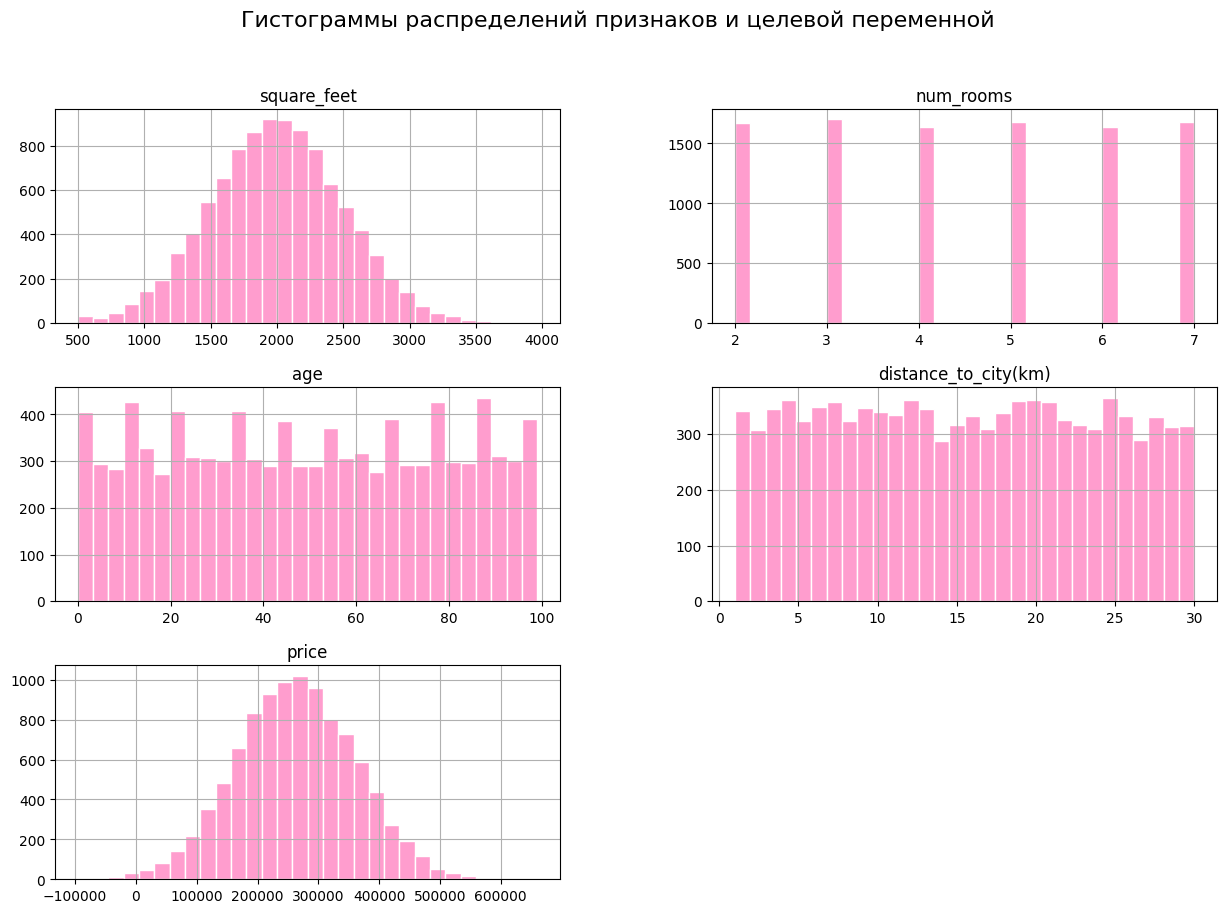

In [66]:
plt.style.use("default")

df_selected.hist(
    bins=30, 
    figsize=(15, 10), 
    color="#ff9dce",
    edgecolor="white"
)

plt.suptitle("Гистограммы распределений признаков и целевой переменной", fontsize=16)
plt.show()


### Промежуточный результат
Исходный датасет содержит 10 000 наблюдений и 5 переменных: square_feet, num_rooms, age, distance_to_city(km) и price.
Пропусков в данных нет, что упрощает этап предобработки.

#### **square_feet:**
**Форма распределения:** распределение визуально близко к нормальному, но с легким смещением влево. Оно не является идеально симметричным.

**Центр распределения:** основная масса данных сосредоточена примерно в интервале от 1500 до 2500 квадратных футов. Это "типичная" площадь для большинства объектов в этом наборе данных.

**Разброс (дисперсия):** данные имеют значительный разброс - от менее 1000 до почти 4000 кв. Это подтверждает вывод из предыдущего анализа о большом стандартном отклонении (~501).

**Мода:** явно выраженный пик (мода) наблюдается в районе 2000 кв. футов. Это самая часто встречающаяся площадь в датасете.
#### **num_room:**
**Тип распределения:** это дискретное распределение. Поскольку количество комнат - целое число, оно отображается не гистограммой, а столбцами.

**Форма распределения:** распределение является мультимодальным (имеет несколько пиков) с явно выраженным главным пиком. Оно не является симметричным.

**Центр распределения:** наибольшее количество объектов имеют 3, 5 и 7 комнат. Это самые распространенные типы планировок в датасете.

**Мода (наиболее частое значение):** главный пик, судя по высоте столбца, находится на значении 3 комнаты. Это самая часто встречающаяся конфигурация.
#### **age:**
**Форма распределения:** распределение является почти идеально равномерным.

**Центр распределения:** у этого распределения нет выраженного центра или пика. Все возрастные категории представлены примерно одинаково.

**Разброс:** Данные равномерно покрывают весь диапазон от 0 до 100 лет.
#### **distance_to_city(km):**
**Форма распределения:** распределение почти равномерное по всей шкале расстояний. Незначительные колебания высоты столбцов связаны с случайными вариациями, но выраженного пика или ярко выраженной тенденции нет.

**Центр распределения:** центр как таковой отсутствует - значения встречаются примерно с одинаковой частотой на всём интервале от 0 до 30 км.

**Особенности:**

* Распределение указывает на то, что дома встречаются на любых расстояниях от центра города примерно одинаково часто.

* Небольшое снижение частоты ближе к границам (0 и 30 км) объясняется тем, что крайние значения обычно встречаются реже по структуре генерации данных.


#### **price:**
**Форма распределения:** hаспределение является нормальным и выглядит довольно симметричным.

**Центр распределения:** центр распределения явно находится в районе 250 000 - 300 000, что полностью совпадает с ранее рассчитанным средним значением (263,011).

**Разброс:** данные симметрично разбросаны в диапазоне от -100,000 до 600,000.

## Корреляционный анализ и мультиколлинеарность
### Стандартизация признаков

In [69]:
from sklearn.preprocessing import StandardScaler

features = ["square_feet", "num_rooms", "age", "distance_to_city(km)"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected[features])
df_scaled = pd.DataFrame(X_scaled, columns=features)

print("Данные после стандартизации:")
df_scaled.head()


Данные после стандартизации:


,square_feet,num_rooms,age,distance_to_city(km)
0,0.497428,-0.873778,1.465395,0.917251
1,-0.136288,-1.458207,-0.949157,-0.165519
2,0.648102,0.879506,-0.569727,0.737421
3,1.521703,-0.873778,0.465081,-0.602847
4,-0.231986,1.463934,0.154638,1.216028


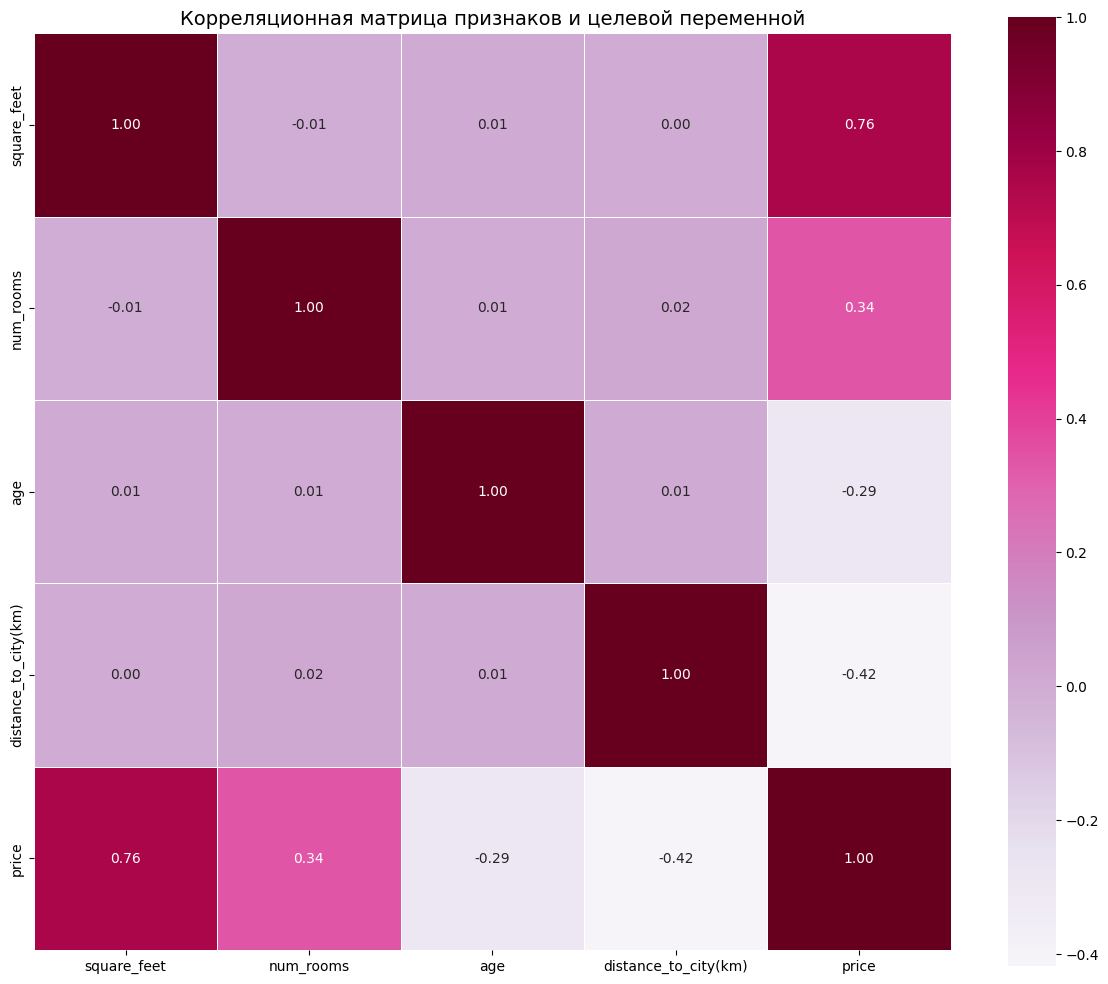

In [70]:
df_with_price = df_selected.copy()

scaler_full = StandardScaler()
df_scaled_full = pd.DataFrame(
    scaler_full.fit_transform(df_with_price), 
    columns=df_with_price.columns
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    df_scaled_full.corr(),
    annot=True,
    cmap="PuRd",
    fmt=".2f",
    linewidths=0.5,
    square=True
)
plt.title("Корреляционная матрица признаков и целевой переменной", fontsize=14)
plt.tight_layout()
plt.show()

Площадь объекта демонстрирует наиболее сильную положительную корреляцию с ценой на уровне +0.76, что определяет ее как ключевой драйвер стоимости. Это означает, что увеличение площади практически линейно приводит к существенному росту рыночной цены объекта.

Вторым по значимости фактором выступает локация - расстояние до города показывает умеренную отрицательную корреляцию -0.42, подтверждая фундаментальный принцип зависимости стоимости недвижимости от географического положения. Каждый километр удаления от городского центра статистически значимо снижает стоимость объекта.

Количество комнат обладает умеренной положительной корреляцией +0.34, однако его влияние существенно слабее площади, что свидетельствует о вторичной важности этого параметра в ценообразовании. Возраст объекта демонстрирует слабую отрицательную корреляцию -0.29, указывая на незначительное снижение стоимости при старении здания.

Особого внимания заслуживает факт практического отсутствия корреляций между независимыми переменными, где все значения находятся в диапазоне от -0.01 до +0.02. Это свидетельствует о статистической независимости факторов и отсутствии мультиколлинеарности, что создает идеальные условия для построения прогнозных моделей множественной регрессии.

#### Расчёт VIF - проверка мультиколлинеарности

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif_data = pd.DataFrame()
vif_data["Признак"] = df_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print("Коэффициенты VIF:")
print(vif_data)


Коэффициенты VIF:
                Признак       VIF
0           square_feet  1.000166
1             num_rooms  1.000361
2                   age  1.000250
3  distance_to_city(km)  1.000425


VIF = 1: Совершенное отсутствие мультиколлинеарности. Признак абсолютно независим от других.

1 < VIF < 5: Умеренная мультиколлинеарность. Обычно приемлемо, модель будет работать нормально.

5 ≤ VIF < 10: Высокая мультиколлинеарность. Коэффициенты становятся нестабильными, их трудно интерпретировать.

VIF ≥ 10: Критическая мультиколлинеарность. Модель ненадёжна, необходимо устранять проблему.

Все значения VIF находятся в диапазоне приблизительно 1.00, что демонстрирует полное отсутствие корреляционной зависимости между признаками. Это означает, что каждый предиктор - площадь, количество комнат, возраст и расстояние до города - статистически независим и не дублирует информацию других переменных.
## Обучение моделей линейной и гребневой регрессии
#### Реализация обучения моделей линейной и гребневой регрессии с использованием кросс-валидации 
Создаем функцию, которая обучает модель и возвращает 3 метрики: RMSE, R², MAPE. Cформируем X и y, проверим корректность передачи данных в модель.

In [79]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    return {"RMSE": rmse, "R²": r2, "MAPE (%)": mape}

X = df_scaled
y = df_selected["price"]

X.head(), y.head()



(   square_feet  num_rooms       age  distance_to_city(km)
 0     0.497428  -0.873778  1.465395              0.917251
 1    -0.136288  -1.458207 -0.949157             -0.165519
 2     0.648102   0.879506 -0.569727              0.737421
 3     1.521703  -0.873778  0.465081             -0.602847
 4    -0.231986   1.463934  0.154638              1.216028,
 0    200374.090410
 1    268784.847337
 2    315020.857676
 3    355111.468459
 4    234197.123903
 Name: price, dtype: float64)

Разделим на train/test

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((8000, 4), (2000, 4))

Основной цикл обучения, просмотрим метрики для каждого алгоритма.

In [81]:
models = {
    "Линейная регрессия": LinearRegression(),
    "Гребневая регрессия": Ridge(alpha=1.0)
}

models

results = []

for name, model in models.items():
    metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
    print(f"\n{name}")
    print("RMSE:", round(metrics["RMSE"], 4))
    print("R²:", round(metrics["R²"], 4))
    print("MAPE (%):", round(metrics["MAPE (%)"], 4))
    
    results.append({"Модель": name, **metrics})



Линейная регрессия
RMSE: 19658.1743
R²: 0.9601
MAPE (%): 15.1006

Гребневая регрессия
RMSE: 19658.2271
R²: 0.9601
MAPE (%): 15.1086


Кросс-валидация

In [82]:
results_cv = []

for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=5, scoring="r2")
    print(f"\nCV R² scores for {name}: {np.round(cv_scores, 5)}")
    print("Средний R² (CV):", round(cv_scores.mean(), 5))

    results_cv.append({
        "Модель": name,
        "R²_CV_mean": cv_scores.mean(),
        "R²_CV_scores": np.round(cv_scores, 5)
    })



CV R² scores for Линейная регрессия: [0.95768 0.95852 0.95421 0.96006 0.96083]
Средний R² (CV): 0.95826

CV R² scores for Гребневая регрессия: [0.95768 0.95852 0.95421 0.96006 0.96083]
Средний R² (CV): 0.95826


Финальная таблица результата

In [83]:
results_df = pd.DataFrame(results)

results_df["R²_CV_mean"] = [d["R²_CV_mean"] for d in results_cv]
results_df["R²_CV_scores"] = [d["R²_CV_scores"] for d in results_cv]

results_df


,Модель,RMSE,R²,MAPE (%),R²_CV_mean,R²_CV_scores
0,Линейная регрессия,19658.174317,0.960064,15.100638,0.958262,"[0.95768, 0.95852, 0.95421, 0.96006, 0.96083]"
1,Гребневая регрессия,19658.227127,0.960063,15.108597,0.958262,"[0.95768, 0.95852, 0.95421, 0.96006, 0.96083]"


Линейная и гребневая регрессии показывают практически идентичные результаты.

Высокое значение R² (~0.96) говорит о том, что модель хорошо объясняет вариацию цены.

Ошибка RMSE составляет ~19.6 тыс., что является приемлемым уровнем для ценовых данных.

Гребневая регрессия не даёт улучшения, что логично при отсутствии мультиколлинеарности.
## Метод главных компонент (PCA)


In [73]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(df_scaled)

print("Форма данных ДО PCA:", df_scaled.shape)
print("Форма данных ПОСЛЕ PCA:", X_pca.shape)

explained_var = pca.explained_variance_ratio_
print("Доля объяснённой дисперсии компонентами:", explained_var)
print("Суммарно объясняется:", explained_var.sum())


Форма данных ДО PCA: (10000, 4)
Форма данных ПОСЛЕ PCA: (10000, 4)
Доля объяснённой дисперсии компонентами: [0.25590915 0.25227339 0.24684814 0.24496932]
Суммарно объясняется: 1.0000000000000002


В данном фрагменте выполняется метод главных компонент (PCA) с сохранением 95% объяснённой дисперсии.

PCA используется для устранения мультиколлинеарности и уменьшения размерности данных. Однако в данном наборе данных признаки независимы, поэтому PCA сохраняет все четыре компоненты, что подтверждается результатами.

Так как каждая компонента объясняет примерно равную часть дисперсии, уменьшить размерность невозможно — PCA оставляет все 4 компоненты.
#### Метод локтя для PCA


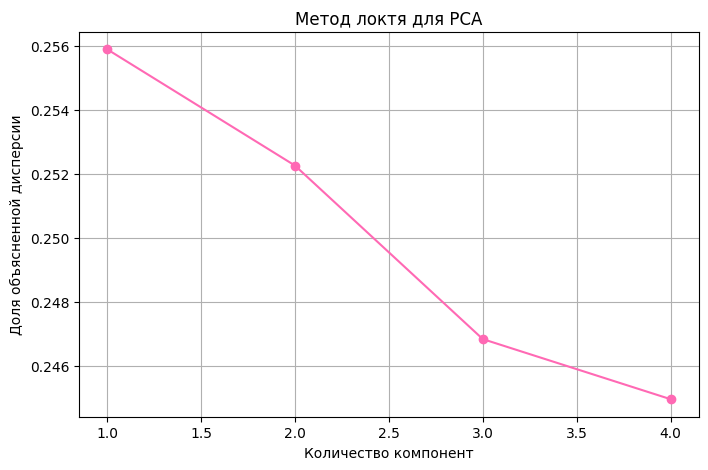

In [74]:
pca_full = PCA().fit(df_scaled)
explained_variance_ratio = pca_full.explained_variance_ratio_

plt.figure(figsize=(8,5))
plt.plot(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    marker='o',
    color="#ff69b4"
)
plt.grid(True)
plt.xlabel("Количество компонент")
plt.ylabel("Доля объясненной дисперсии")
plt.title("Метод локтя для PCA")
plt.show()


Кривая плавно убывает от 0.256 -> 0.245 без ярко выраженного «локтя». Это означает, что нет точки, где можно было бы убрать компоненты без потери значимой информации. Следовательно, размерность данных уменьшить нельзя.
#### Обучение моделей на данных после PCA
После преобразования данных PCA повторно выполним обучение линейной и гребневой моделей. Используем ту же функцию evaluate_model() и такую же схему кросс-валидации.
Этот шаг необходим для сравнения качества моделей до и после PCA.

In [ ]:
def run_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    models = {
        "Линейная регрессия": LinearRegression(),
        "Гребневая регрессия": Ridge(alpha=1.0)
    }
    
    results = []
    for name, model in models.items():
        metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
        cv_scores = cross_val_score(model, X, y, cv=5, scoring="r2")
        
        metrics["R²_CV_mean"] = cv_scores.mean()
        metrics["R²_CV_scores"] = np.round(cv_scores, 5)

        results.append({"Модель": name, **metrics})
        
    return pd.DataFrame(results)

results_pca = run_models(X_pca, df_selected["price"])
results_pca


,Модель,RMSE,R²,MAPE (%),R²_CV_mean,R²_CV_scores
0,Линейная регрессия,19658.174317,0.960064,15.100638,0.958262,"[0.95768, 0.95852, 0.95421, 0.96006, 0.96083]"
1,Гребневая регрессия,19658.227127,0.960063,15.108597,0.958262,"[0.95768, 0.95852, 0.95421, 0.96006, 0.96083]"


Так как PCA не уменьшил размерность и не изменил структуру данных, качество моделей осталось неизменным.
## Сравнение моделей до/после PCA

In [12]:
comparison_df = pd.concat([
    results_df.assign(Данные="До PCA"),
    results_pca.assign(Данные="После PCA")
])

comparison_df


,Модель,RMSE,R²,MAPE (%),R²_CV_mean,R²_CV_scores,Данные
0,Линейная регрессия,19658.174317,0.960064,15.100638,0.958262,"[0.95768, 0.95852, 0.95421, 0.96006, 0.96083]",До PCA
1,Гребневая регрессия,19658.227127,0.960063,15.108597,0.958262,"[0.95768, 0.95852, 0.95421, 0.96006, 0.96083]",До PCA
0,Линейная регрессия,19658.174317,0.960064,15.100638,0.958262,"[0.95768, 0.95852, 0.95421, 0.96006, 0.96083]",После PCA
1,Гребневая регрессия,19658.227127,0.960063,15.108597,0.958262,"[0.95768, 0.95852, 0.95421, 0.96006, 0.96083]",После PCA


Линейная и гребневая регрессии показали идентичные результаты, что свидетельствует об отсутствии мультиколлинеарности между признаками и достаточной устойчивости моделей. Значения метрик качества (RMSE ≈ 19,6 тыс., R² ≈ 0.96, MAPE ≈ 15%) демонстрируют высокую точность предсказания. Гребневая регуляризация с параметром α = 1.0 не привела к улучшению показателей, что подтверждает независимость признаков и отсутствие необходимости в регуляризации.

Применение метода главных компонент (PCA) не изменило качество моделей: количество компонент осталось прежним, так как каждый исходный признак объясняет сопоставимую долю дисперсии. Метрики моделей после PCA полностью совпали с результатами до применения метода. Это ожидаемо, поскольку PCA эффективно снижает размерность только при наличии сильной корреляции между признаками.

Все значения метрик MAPE находятся ниже порогового значения 20%, что позволяет считать точность модели удовлетворительной для практического применения.